$\newcommand{\calf}{{\cal F}}
\newcommand{\dnu}{d \nu}
\newcommand{\dmu}{d \mu}
\newcommand{\dmup}{d \mu'}
\newcommand{\vf}{{\bf f}}
\newcommand{\vq}{{\bf q}}
\newcommand{\mg}{{\bf G}}
\newcommand{\mK}{{\bf K}}
$

In [1]:
include("nda_note.jl")

[ Info: Precompiling NDA_QMC [top-level]


# Problems with NDA and QMC

Here are the things I've been doing to figure out what the problems are.

The first thing is to see if the low-order problem is correct. I know that the QMC code is returning good cell-average fluxes because I'm getting good results with the Krylov solves. So I will check the coefficients and boundary conditions of the low-order problem

$$
\frac{d}{dx}\left[ -\frac{1}{3\Sigma_t} \frac{d\phi}{dx} + \hat{D} \phi\right] + (\Sigma_t - \Sigma_s)\phi = q,
$$
with boundary conditions $\phi(0)=\phi^{HO}(0)$ and $\phi(\tau)=\phi^{HO}(\tau)$. For our example $q=0$.

The coefficient is
$$
{\hat D} = \frac{ J^{HO} + \frac{1}{3} \frac{d \phi^{HO}}{dx} } {\phi^{HO}},
$$

In my formulation $\hat D$ is a cell-average qantity and the low-order flux $\phi$ is a cell edge quantity.
As you saw from my email of July 13, the QMC code returns strange cell-edge valueds for the flux. The QMC code then differentiaes the edge values numerically to get $d \phi/dx$. NDA with that $d \phi/dx$ diverges.

I fixed(?) that by taking using the cell averages to get cell edges and then differentiate that numerically. The Julia code for that is
```Julia
function avg2edge!(phi_edge, dphi, phi_avg, dx,AVE)
Nx=length(phi_avg)
m=length(phi_edge)
Nx==length(dphi) || error("dphi lives on cell centers")
m == Nx+1 || error("edges and averages fail to match")
phi_edge[1]=1.5*phi_avg[1] - .5*phi_avg[2]
for ie=2:Nx
phi_edge[ie] = .5*(phi_avg[ie-1]+phi_avg[ie])
end
phi_edge[Nx+1]=1.5*phi_avg[Nx] - .5*phi_avg[Nx-1]
cphi=copy(phi_edge)
aphi=AVE*cphi
for id=1:Nx
#dphi[id]=(phi_edge[id+1]-phi_edge[id])/dx
dphi[id]=(aphi[id+1]-aphi[id])/dx
end
#return (phi_edge=phi_edge, dphi=dphi)
phi_edge .= aphi
return (phi_edge=aphi, dphi=dphi)
end
```
The NDA iteration no longer diverges, but the solution is terrible and is discontinuous at the right boundary. Here's a plot. I'm using my very questionable implementation ```qmc_nda.jl``` for this. All the codes I use for QMC work in this note book are in the __src/Tim_QMC__ directory. 

Here are a few sanity checks to see what the fluxes and the derivative $d \phi/dx$ look like. I'll repeat
the computation from the email first and them compare my fix to what I get from a standard SN transport sweep. Here's the script and plot from the email.

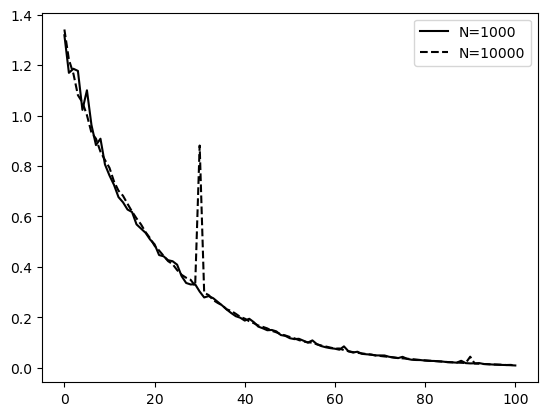

PyObject <matplotlib.legend.Legend object at 0x18a111fd0>

In [2]:
Nx=100;
na2=11;
s=1.0;
phit=ones(Nx,);
data1=qmc_init(1000,Nx,na2,s);
data2=qmc_init(10000,Nx,na2,s);
phiout1=qmc_sweep(phit, data1);
phiout2=qmc_sweep(phit, data2);
plot(phiout1.phi_edge,"k-");
plot(phiout2.phi_edge,"k--");
legend(["N=1000", "N=10000"])

Now look at the average values. They do get smoother as N increases.

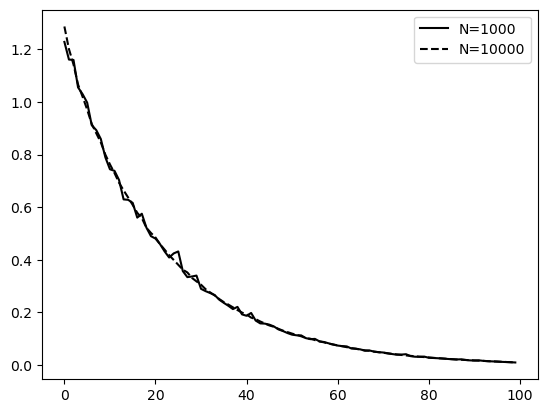

PyObject <matplotlib.legend.Legend object at 0x219a6cfa0>

In [3]:
plot(phiout1.phi_avg,"k-");
plot(phiout2.phi_avg,"k--");
legend(["N=1000", "N=10000"])

Now here's trouble. The average flux looks pretty decent, but has jumps all over. This 
spells trouble for $d \phi/dx$. Even the small fluctuations elsehwere lead to big problems with dphi. So $d \phi/dx$ is nuts and I may have to do the smoothing unless you can get me a $d \phi/dx$ directly from QMC (ie with no difference approximation).

Start by setting up the plain vanill sn_data to have the same number of cells (Nx) as qmc.

In [4]:
nx=Nx+1;
na2=20;
s=1.0;
sn_data=sn_init(nx, na2, s);
dx=sn_data.dx;
AVE=data2.AV;

Now try to average the qmc cell average fluxes and get dphi and phi_edge from that.

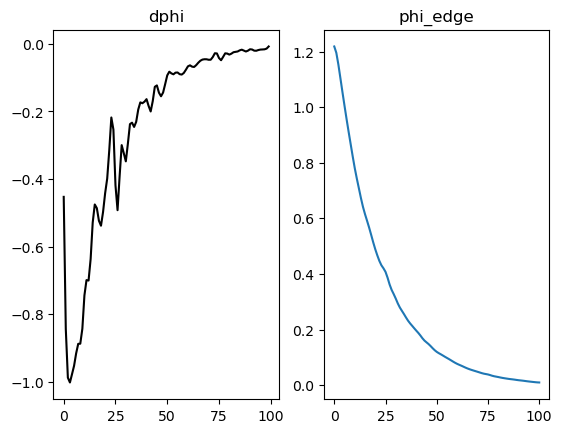

PyObject Text(0.5, 1.0, 'phi_edge')

In [5]:
phi_avg=phiout1.phi_avg;
phi_edge=zeros(Nx+1,);
dphi=zeros(Nx,);
avg2edge!(phi_edge, dphi, phi_avg, dx, AVE)
subplot(1,2,1)
plot(dphi,"k-")
title("dphi")
subplot(1,2,2)
plot(phi_edge)
title("phi_edge")

With the new averaging, the edge fluxes look good, but the derivative is still very irregular.

In [6]:
x1=phiout1.phi_avg[95:100];
x2=phiout1.phi_avg[1:6];
[x1 x2]

6×2 Matrix{Float64}:
 1.34766e-02  1.22819e+00
 1.28357e-02  1.16107e+00
 1.17485e-02  1.15960e+00
 1.10119e-02  1.05521e+00
 1.03482e-02  1.02942e+00
 9.38162e-03  9.97419e-01

If I take dphi/dx directly from the QMC code I get in real trouble.

In [45]:
#plain vanilla SN with simple source iteration
snout=sn_solve();
#QMC with simple source iteration, works fine
qout=qmc_nda(2000, 100, 1.e-7;tabulate=true, nda=false)
#QMC with NDA
pout=qmc_nda(1000,200, 1.e-7; tabulate=true);



QMC Exit Distributions
 mu         I(0,-mu)        I(tau,mu) 
 0.05     5.88610e-01     5.91510e-06 
 0.10     5.32786e-01     6.73579e-06 
 0.20     4.47388e-01     9.34555e-06 
 0.30     3.85095e-01     1.55884e-05 
 0.40     3.37848e-01     4.12782e-05 
 0.50     3.00853e-01     1.58181e-04 
 0.60     2.71128e-01     5.37995e-04 
 0.70     2.46732e-01     1.42872e-03 
 0.80     2.26355e-01     3.08198e-03 
 0.90     2.09082e-01     5.69219e-03 
 1.00     1.94256e-01     9.37139e-03 
9.07862e-01  1.02383e-03
9.21251e-01  2.07430e-03
9.20063e-01  3.43624e-03
9.19146e-01  5.55134e-03
9.19077e-01  9.87187e-03
9.19102e-01  2.17853e-02
9.19208e-01  5.99507e-02
9.19568e-01  1.83894e-01
9.20748e-01  5.91327e-01
9.24582e-01  1.92327e+00
9.36820e-01  6.19085e+00
9.75636e-01  1.97509e+01
1.09862e+00  6.27392e+01
1.48813e+00  1.98915e+02
2.72156e+00  6.30149e+02
6.62698e+00  1.99560e+03
1.89923e+01  6.31890e+03
5.81428e+01  2.00071e+04
1.82098e+02  6.33459e+04
5.74555e+02  2.00562e+05
1.81712e+

Here's a plot of the converged fluxes. QMC and SN agree without NDA and QMC-NDA is wrong.

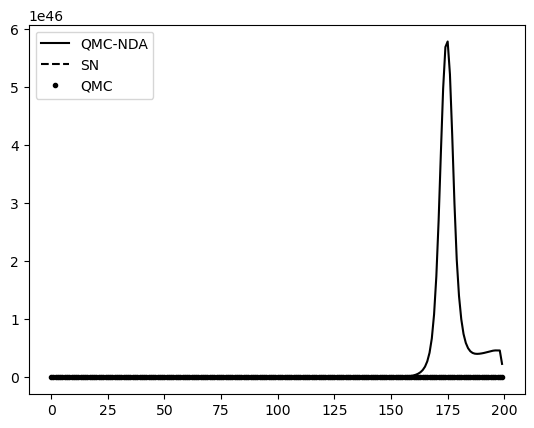

PyObject <matplotlib.legend.Legend object at 0x219ca5eb0>

In [17]:
plot(pout.phiout,"k-")
plot(snout,"k--")
plot(qout.phiout,"k.")
legend(["QMC-NDA","SN","QMC"])